# Data sets preparation for investigating pooling-imputation performance from real bead chip data with low- and high-density genotyped markers

Use data from the chromosome 20 of 1000GP intersected with markers on real bead chips
 manufactured by Illumina :
* High-density genotyped markers (HD markers): Illumina Infinium OmniExpress2.5 - 8 Kit
  (https://support.illumina.com/array/array_kits/humanomniexpress2.5-8-beadchip-kit/downloads.html) 
* Low-density genotyped markers (HD markers): Illumina Infinium OmniExpress - 24 Kit
  (https://support.illumina.com/array/array_kits/humanomniexpress-24-beadchip-kit/downloads.html) 
 
## Preparation
Prepare data sources and sets, reconfigure paths and directories
* Renamed /home/camille/PoolImpHuman/data/omniexpress into /home/camille/PoolImpHuman/data/20200624
* /home/camille/PoolImpHuman/data/omniexpress8 is supposed to contain the physical coordinates of markers on the Illumina bead chip **OmniExpress2.5 - 8 Kit** + the intersected chr20 markers from the 1KGP + code for creating the files. This is the **high-density set of markers**. 
* /home/camille/PoolImpHuman/data/omniexpress24 is supposed to contain the physical coordinates of markers on the Illumina bead chip **OmniExpress - 24 Kit** + the intersected chr20 markers from the 1KGP + code for creating the files. This is the **low-density set of markers**. 

## Description
This experiment aims to compare the performance of two approaches for genotyping markers at high-density:
1. Approach#1 serves as baseline: usual case study of imputing markers in a population genotyped at low-density, using a reference panel genotyped at high-density
2. Approach#2 evaluates achieving genotyping of markers at high-density from pools of individuals all genotyped at high-density (1 block of pool per bead chip with the chosen pooling scheme and bead chip model)

## EDA of bead chips

#### How many markers per bead chip? Does this correspond to proper low and high densities?
* OmniExpress24 intersects 17,791 markers of the 1KGP chr20
* OmniExpress8 intersects 52,697 markers of the 1KGP chr20
 
~~Not enough density difference? Try with even more sparse chip like Infinium Core 24?~~

* GWAS 2010: "Imputation of 500 (1000) samples genotyped at 872 SNPs from 1000 haplotypes at 8712 SNPs a 5Mb region" --> ratio 1:10 number of refpan:target SNPs
* chromosome 20 Mb size? Approx. 64Mb (millions of base pairs) reported last. In 1KGP: from POS 60,343 to POS 62,965,354 --> 62,905,011 i.e. 63Mb
```bash
~/PoolImpHuman/data/main$ bcftools query -f '%POS\n' ALL.chr20.snps.gt.vcf.gz | head -1
60343

~/PoolImpHuman/data/main$ bcftools query -f '%POS\n' ALL.chr20.snps.gt.vcf.gz | tail -1
62965354

In [1]:
import os, sys

rootdir = os.path.dirname(os.path.dirname(os.getcwd()))
print(rootdir)
sys.path.insert(0, rootdir)

try:
    os.mkdir('/home/camille/PoolImpHuman/data/omniexpress-isec-LDHD')
except FileExistsError:
    pass
os.chdir('/home/camille/PoolImpHuman/data/omniexpress-isec-LDHD')

from VCFPooling.poolSNPs import dataframe as vcfdf

/home/camille/1000Genomes/src


In [2]:
print('Configure directory')
%sx ln -s ../20200812/isec ./
%sx ln -s ../20200812/IMP.chr20.snps.gt.vcf.gz ./IMP.chr20.snps.gt.fullHD.vcf.gz
%sx ln -s ../20200812/IMP.chr20.snps.isecgt.vcf.gz ./IMP.chr20.snps.gt.fullLD.vcf.gz
# Display contents of isec subfolder
%sx cat isec/README.txt

Configure directory


['This file was produced by vcfisec.',
 'The command line was:\tbcftools isec  -p ./isec ../20200710/IMP.chr20.pooled.snps.gl.vcf.gz IMP.chr20.snps.gt.vcf.gz',
 '',
 'Using the following file names:',
 './isec/0000.vcf\tfor records private to\t../20200710/IMP.chr20.pooled.snps.gl.vcf.gz',
 './isec/0001.vcf\tfor records private to\tIMP.chr20.snps.gt.vcf.gz',
 './isec/0002.vcf\tfor records from ../20200710/IMP.chr20.pooled.snps.gl.vcf.gz shared by both\t../20200710/IMP.chr20.pooled.snps.gl.vcf.gz IMP.chr20.snps.gt.vcf.gz',
 './isec/0003.vcf\tfor records from IMP.chr20.snps.gt.vcf.gz shared by both\t../20200710/IMP.chr20.pooled.snps.gl.vcf.gz IMP.chr20.snps.gt.vcf.gz']

```
This file was produced by vcfisec.
The command line was:	bcftools isec  -p ./isec ../20200710/IMP.chr20.pooled.snps.gl.vcf.gz IMP.chr20.snps.gt.vcf.gz

Using the following file names:
./isec/0000.vcf	for records private to	../20200710/IMP.chr20.pooled.snps.gl.vcf.gz
./isec/0001.vcf	for records private to	IMP.chr20.snps.gt.vcf.gz
./isec/0002.vcf	for records from ../20200710/IMP.chr20.pooled.snps.gl.vcf.gz shared by both	../20200710/IMP.chr20.pooled.snps.gl.vcf.gz IMP.chr20.snps.gt.vcf.gz
./isec/0003.vcf	for records from IMP.chr20.snps.gt.vcf.gz shared by both	../20200710/IMP.chr20.pooled.snps.gl.vcf.gz IMP.chr20.snps.gt.vcf.gz
```

In [3]:
m_files = {
    'fullLD': vcfdf.PandasMixedVCF('IMP.chr20.snps.gt.fullLD.vcf.gz', format='GT', indextype='id'),
    'fullHD': vcfdf.PandasMixedVCF('IMP.chr20.snps.gt.fullHD.vcf.gz', format='GT', indextype='id'),
    'onlyLD': vcfdf.PandasMixedVCF('./isec/0000.vcf', format='GT', indextype='id'),
    'onlyHD': vcfdf.PandasMixedVCF('./isec/0001.vcf', format='GT', indextype='id'),
    'isecLDHD': vcfdf.PandasMixedVCF('./isec/0002.vcf', format='GT', indextype='id')
}

# markers counts
m_counts = {}
for f, obj in m_files.items():
    m_counts[f] = len(obj.variants)
    
print(m_counts)

{'fullLD': 17791, 'fullHD': 52697, 'onlyLD': 776, 'onlyHD': 35682, 'isecLDHD': 17015}


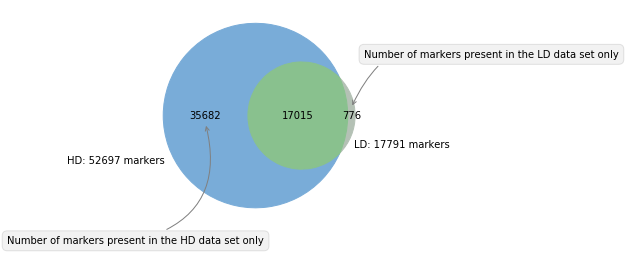

In [8]:
outdir = '/home/camille/PoolImpHuman/results/omniexpress-isec-LDHD'
if not os.path.exists(outdir):
    os.mkdir(outdir)
    
hdcolor = '#79acd8'
ldcolor = '#89c18e'
outcolor = '#b4c1b5'

# %sx pip3 install matplotlib-venn

import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

plt.figure(figsize=(12,4))
v = venn2(subsets = (m_counts['onlyHD'], m_counts['onlyLD'], m_counts['isecLDHD']), 
      set_labels = ('', ''), alpha = 1.0)
v.get_patch_by_id('10').set_color(hdcolor)
v.get_patch_by_id('01').set_color(outcolor)
v.get_patch_by_id('11').set_color(ldcolor)
#plt.title("Venn diagram of the makers composition on the Illumina bead-chips Omni2.5 - 8 (HD) and Omniexpress - 24 (LD)")

plt.annotate('Number of markers present in the HD data set only', xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-120),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('HD: {} markers'.format(m_counts['fullHD']), xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-90,-40),
             ha='center', textcoords='offset points')

plt.annotate('Number of markers present in the LD data set only', xy=v.get_label_by_id('01').get_position() + np.array([0, 0.05]), xytext=(140,50),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('LD: {} markers'.format(m_counts['fullLD']), xy=v.get_label_by_id('01').get_position() + np.array([0, 0.05]), xytext=(50,-40),
             ha='center', textcoords='offset points')

plt.savefig(os.path.join(outdir, 'venn-diagram-LDHD.pdf'))
plt.show()


In [ ]:
plt.show()
